<a href="https://colab.research.google.com/github/Rizki135196/ANALISIS-SENTIMEN-MUSLIM-PRO-INDONESIA/blob/main/Pemodelan_Sentimen_Analisis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sastrawi
!pip install tensorflow
!pip install scikit-learn
!pip install pandas nltk wordcloud requests matplotlib seaborn
!pip install lightgbm xgboost catboost
!pip install dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
import requests
import json
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
import time
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
import pandas as pd

# Membaca file CSV hasil scraping Muslim Pro Indonesia
df = pd.read_csv('/content/review_muslimpro.csv', encoding='utf-8', quotechar='"', escapechar='\\')

# Menampilkan 5 baris pertama dari DataFrame
df.head()

,userName,score,at,content
0,Andi Welder,2,2025-07-24 13:25:05,Iklannya banyak fto gak genah
1,Gamer Net,1,2025-07-24 12:50:44,buruk
2,Dedi Gunawan,1,2025-07-24 11:22:20,Assalamualaikum warahmatullahi wabarokatu slmt...
3,Diana,5,2025-07-24 10:48:41,"aplikasi yang sangat"" berguna dan bermanfaat t..."
4,NASRUDIN,5,2025-07-24 10:35:57,good ilike


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
clean_df = df.dropna()

In [ ]:
clean_df = clean_df.drop_duplicates()

In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  200 non-null    object
 1   score     200 non-null    int64 
 2   at        200 non-null    object
 3   content   200 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.4+ KB


In [ ]:
clean_df.head()

,userName,score,at,content
0,Andi Welder,2,2025-07-24 13:25:05,Iklannya banyak fto gak genah
1,Gamer Net,1,2025-07-24 12:50:44,buruk
2,Dedi Gunawan,1,2025-07-24 11:22:20,Assalamualaikum warahmatullahi wabarokatu slmt...
3,Diana,5,2025-07-24 10:48:41,"aplikasi yang sangat"" berguna dan bermanfaat t..."
4,NASRUDIN,5,2025-07-24 10:35:57,good ilike


In [ ]:
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Jika belum di-download, jalankan ini dulu:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

# Jika kamu punya kamus slangwords (jika tidak, buat dictionary kosong dulu)
slangwords = {
    'gk': 'tidak',
    'tp': 'tapi',
    'udh': 'sudah',
    'blm': 'belum',
    # tambah sesuai kebutuhan
}

def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Buang kata-kata tidak relevan untuk Muslim Pro (ganti daftar sesuai kebutuhanmu)
    kata_dibuang = ["muslim", "pro", "indonesia", "app"]  # <- ini bisa diubah sesuai relevansi
    text = ' '.join([word for word in text.split() if word.lower() not in kata_dibuang])

    text = text.strip(' ')
    return text

def casefoldingText(text):
    return text.lower()

def tokenizingText(text):
    return word_tokenize(text)

def filteringText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku','di','ya','loh','kah','deh'])  # Tambahan informal
    filtered = [txt for txt in text if txt not in listStopwords]
    return filtered

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

def toSentence(list_words):
    return ' '.join(list_words)

def fix_slangwords(text):
    words = text.split()
    fixed_words = [slangwords[word.lower()] if word.lower() in slangwords else word for word in words]
    return ' '.join(fixed_words)

In [ ]:
import requests
import json

url = 'https://raw.githubusercontent.com/Rizki135196/ai-uas-2025/refs/heads/main/data/slangwords.json'

response = requests.get(url)

if response.status_code == 200:
    try:
        slangwords = json.loads(response.text)
        print("Slangwords berhasil dimuat.")
    except json.JSONDecodeError as e:
        print("Error decoding JSON:", e)
        print("Response content:", response.text)
else:
    print("Failed to fetch data from URL. Status code:", response.status_code)


Slangwords berhasil dimuat.


In [ ]:
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

In [ ]:
clean_df.head()

,userName,score,at,content,text_clean,text_casefoldingText,text_slangwords,text_tokenizingText,text_stopword,text_akhir
0,Andi Welder,2,2025-07-24 13:25:05,Iklannya banyak fto gak genah,Iklannya banyak fto gak genah,iklannya banyak fto gak genah,iklannya banyak fto gak genah,"[iklannya, banyak, fto, gak, genah]","[iklannya, fto, genah]",iklannya fto genah
1,Gamer Net,1,2025-07-24 12:50:44,buruk,buruk,buruk,buruk,[buruk],[buruk],buruk
2,Dedi Gunawan,1,2025-07-24 11:22:20,Assalamualaikum warahmatullahi wabarokatu slmt...,Assalamualaikum warahmatullahi wabarokatu slmt...,assalamualaikum warahmatullahi wabarokatu slmt...,assalamualaikum warahmatullahi wabarokatu slmt...,"[assalamualaikum, warahmatullahi, wabarokatu, ...","[assalamualaikum, warahmatullahi, wabarokatu, ...",assalamualaikum warahmatullahi wabarokatu slmt...
3,Diana,5,2025-07-24 10:48:41,"aplikasi yang sangat"" berguna dan bermanfaat t...",aplikasi yang sangat berguna dan bermanfaat te...,aplikasi yang sangat berguna dan bermanfaat te...,aplikasi yang sangat berguna dan bermanfaat te...,"[aplikasi, yang, sangat, berguna, dan, bermanf...","[aplikasi, berguna, bermanfaat, terimakasih, p...",aplikasi berguna bermanfaat terimakasih penyel...
4,NASRUDIN,5,2025-07-24 10:35:57,good ilike,good ilike,good ilike,good ilike,"[good, ilike]","[good, ilike]",good ilike


In [ ]:
def load_lexicon(url):
    lexicon = dict()
    response = requests.get(url)

    if response.status_code == 200:
        lines = response.text.strip().split('\n')
        for line in lines:
            parts = line.split(',')
            word = ','.join(parts[:-1])
            score = parts[-1]
            lexicon[word.strip()] = int(score.strip())
    else:
        print(f"Failed to fetch lexicon data from {url}")

    return lexicon

positive_lexicon_url = 'https://raw.githubusercontent.com/Rizki135196/ai-uas-2025/refs/heads/main/data/positive_lexicon.txt'
negative_lexicon_url = 'https://raw.githubusercontent.com/Rizki135196/ai-uas-2025/refs/heads/main/data/negative_lexicon.txt'

# Memuat leksikon positif dan negatif dari URL yang diberikan
lexicon_positive = load_lexicon(positive_lexicon_url)
lexicon_negative = load_lexicon(negative_lexicon_url)

In [ ]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        if (word in lexicon_positive):
            score = score + lexicon_positive[word]

    for word in text:
        if (word in lexicon_negative):
            score = score + lexicon_negative[word]

    polarity = ''

    if (score > 0):
        polarity = 'positive'
    elif (score < 0):
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [ ]:
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)


results = list(zip(*results))

clean_df['polarity_score'] = results[0]

clean_df['polarity'] = results[1]

print(clean_df['polarity'].value_counts())

polarity
neutral     123
positive     67
negative     10
Name: count, dtype: int64


In [ ]:
X = clean_df['text_akhir']
y = clean_df['polarity']

In [ ]:
tfidf = TfidfVectorizer(max_features=200, min_df=17, max_df=0.8, ngram_range=(1, 1))
X_tfidf = tfidf.fit_transform(X)

In [ ]:
features_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
features_df

,aplikasi,bagus,banget,iklan,iklannya,membantu
0,0.000000,0.000000,0.0,0.0,1.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0
2,1.000000,0.000000,0.0,0.0,0.0,0.0
3,1.000000,0.000000,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
195,0.000000,0.000000,0.0,1.0,0.0,0.0
196,0.000000,0.000000,0.0,0.0,0.0,1.0
197,0.000000,0.000000,0.0,0.0,0.0,0.0
198,0.000000,0.000000,0.0,0.0,0.0,0.0


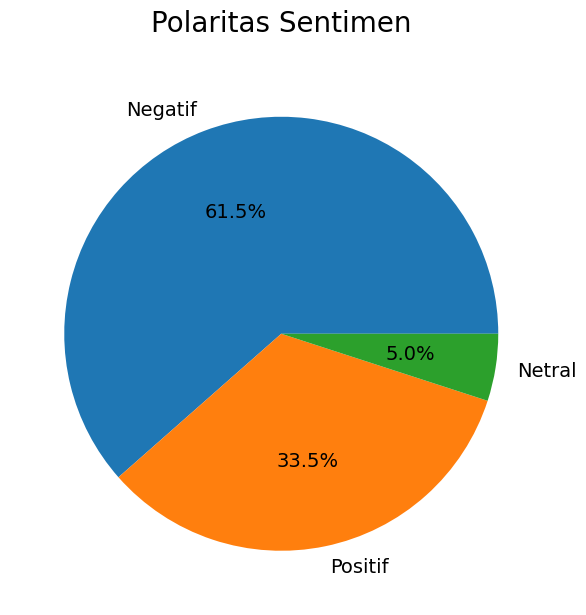

In [ ]:
fig, ax = plt.subplots(figsize=(7, 8))
sizes = [count for count in clean_df['polarity'].value_counts()]
#labels = list(clean_df['polarity'].value_counts().index)  # Mengambil nama kategori polaritas sentimen
labels = ['Negatif', 'Positif', 'Netral']
explode = (0, 0, 0)
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Polaritas Sentimen', fontsize=20, pad=22)
plt.show()

In [ ]:
positive_review = clean_df[clean_df['polarity'] == 'positive']
positive_review = positive_review[['text_akhir', 'polarity_score', 'polarity', 'text_stopword']]
positive_review = positive_review.sort_values(by='polarity_score', ascending=False)
positive_review = positive_review.reset_index(drop=True)
positive_review.index += 1

In [ ]:
negative_review = clean_df[clean_df['polarity'] == 'negative']
negative_review = negative_review[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
negative_review = negative_review.sort_values(by='polarity_score', ascending=False)
negative_review = negative_review.reset_index(drop=True)
negative_review.index += 1

In [ ]:
neutral_review = clean_df[clean_df['polarity'] == 'neutral']
neutral_review = neutral_review[['text_akhir', 'polarity_score', 'polarity','text_stopword']]
neutral_review = neutral_review.sort_values(by='polarity_score', ascending=False)
neutral_review = neutral_review.reset_index(drop=True)
neutral_review.index += 1

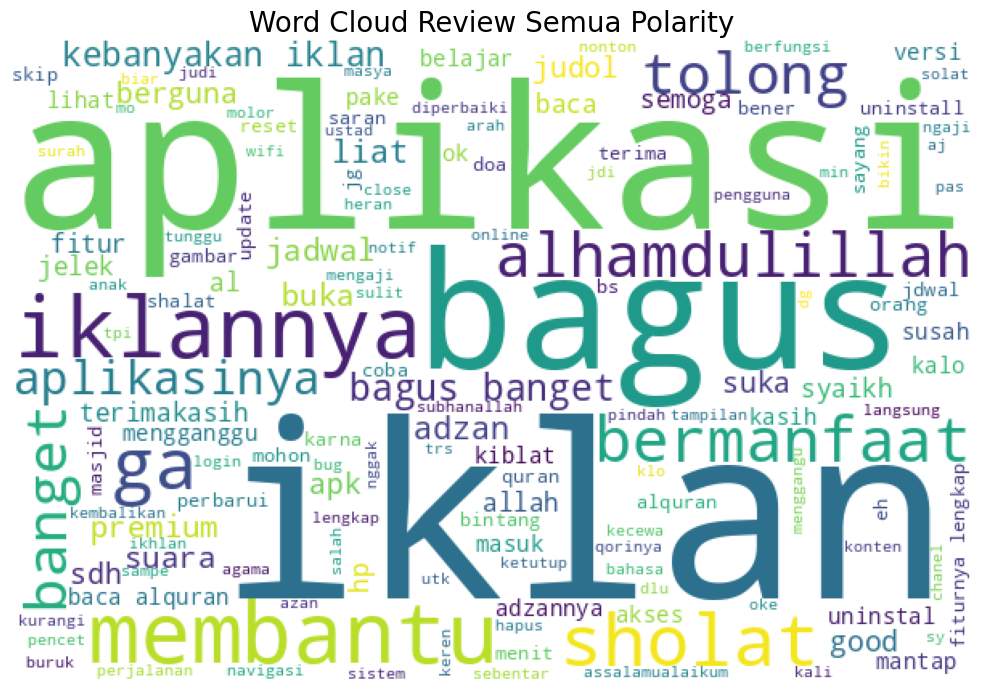

In [ ]:
list_words = ''
for tweet in clean_df['text_stopword']:
    for word in tweet:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Review Semua Polarity', fontsize=20)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

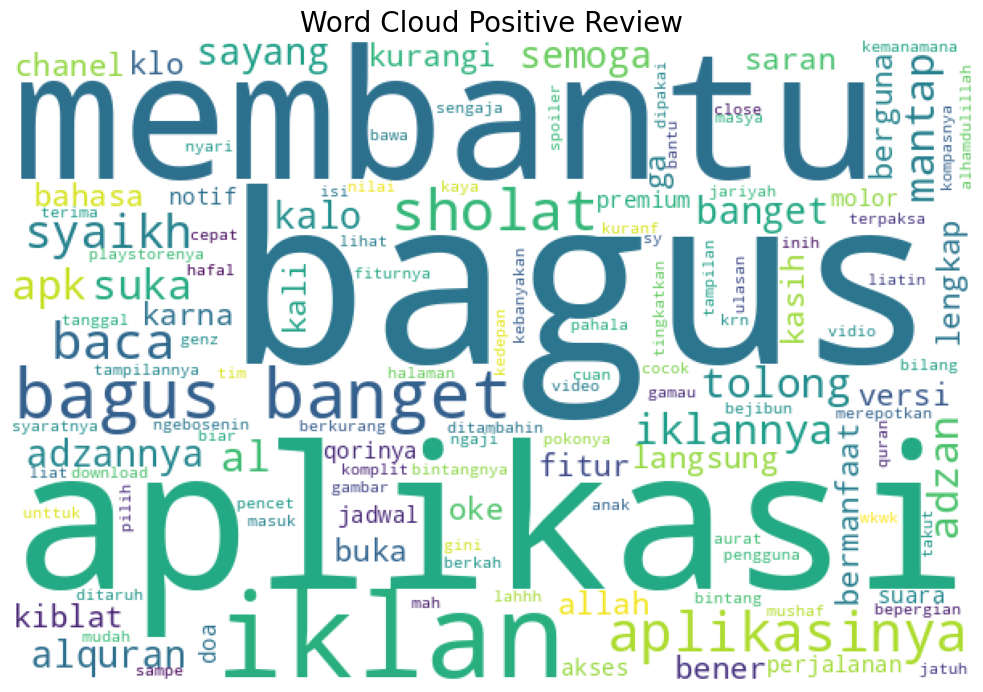

In [ ]:
list_words = ''
for review in positive_review['text_stopword']:
    for word in review:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Positive Review', fontsize=20)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

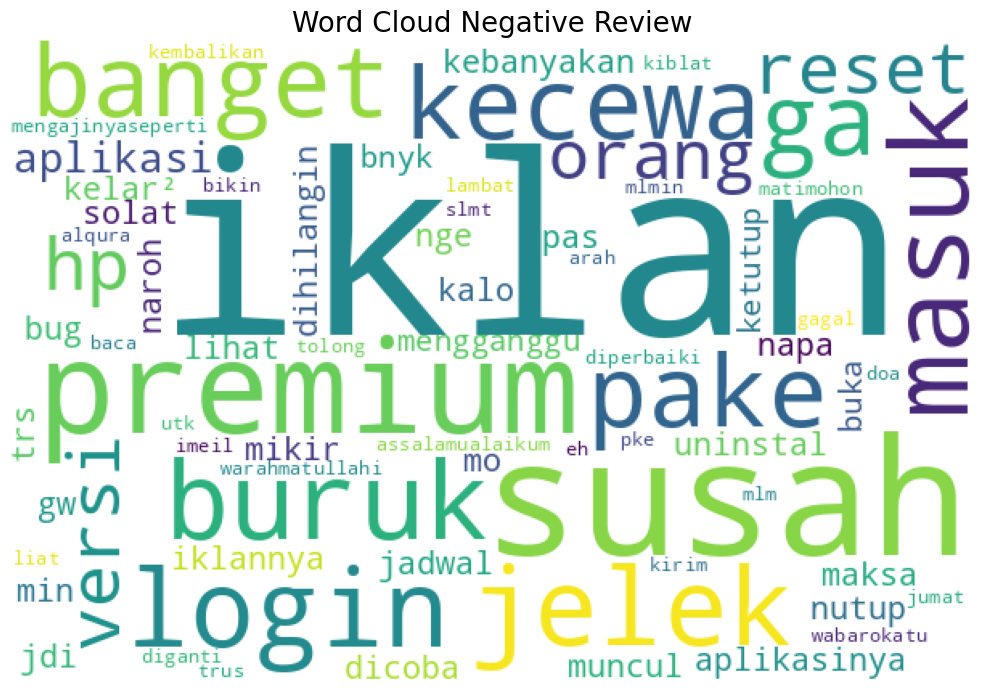

In [ ]:
list_words = ''
for review in negative_review['text_stopword']:
    for word in review:
        list_words += ' ' + (word)

wordcloud = WordCloud(width=600, height=400, background_color='white', min_font_size=10).generate(list_words)
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Word Cloud Negative Review', fontsize=20)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.show()

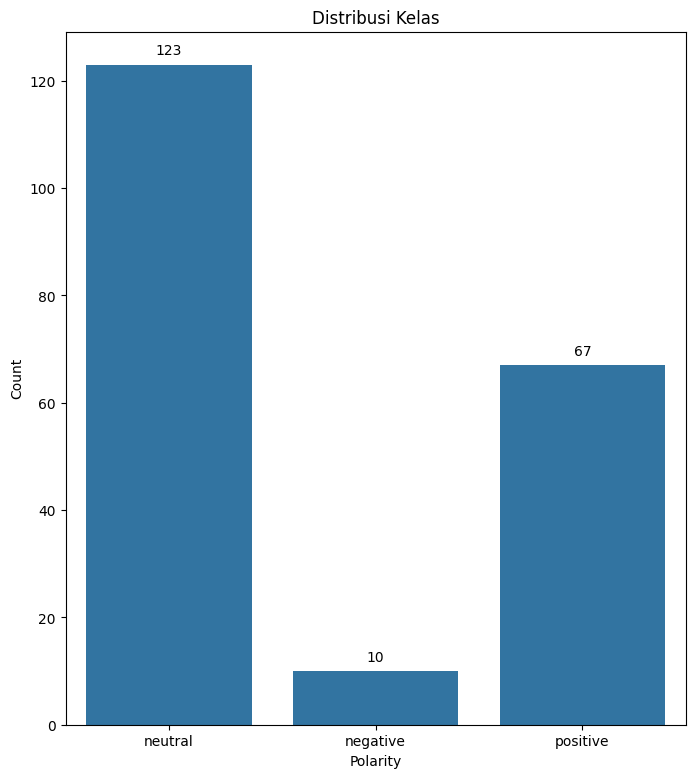

In [ ]:
# Mengatur ukuran gambar plot
plt.figure(figsize=(8, 9))

# Membuat plot count menggunakan seaborn untuk variabel 'polarity' dari dataframe 'clean_df'
class_dist_plot = sns.countplot(x='polarity', data=clean_df)

# Menetapkan judul plot
plt.title('Distribusi Kelas')

# Menetapkan label sumbu x
plt.xlabel('Polarity')

# Menetapkan label sumbu y
plt.ylabel('Count')

# Menambahkan label angka untuk setiap bar pada plot
for p in class_dist_plot.patches:
    class_dist_plot.annotate(format(p.get_height(), '.0f'),
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center',
                             xytext=(0, 10),
                             textcoords='offset points')

# Menampilkan plot
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=50)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Membuat objek model Logistic Regression
logistic_regression = LogisticRegression()

# Melatih model Logistic Regression pada data pelatihan
logistic_regression.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_lr = logistic_regression.predict(X_train.toarray())
y_pred_test_lr = logistic_regression.predict(X_test.toarray())

# Evaluasi akurasi model Logistic Regression pada data pelatihan
accuracy_train_lr = accuracy_score(y_pred_train_lr, y_train)

# Evaluasi akurasi model Logistic Regression pada data uji
accuracy_test_lr = accuracy_score(y_pred_test_lr, y_test)

# Menampilkan akurasi
print('Logistic Regression - accuracy_train:', accuracy_train_lr)
print('Logistic Regression - accuracy_test:', accuracy_test_lr)

Logistic Regression - accuracy_train: 0.88125
Logistic Regression - accuracy_test: 0.95


In [ ]:
# Mengonversi sparse matrix ke array
X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Membuat objek model XGBoost
xgb = XGBClassifier(n_estimators=100, random_state=42)

# Melatih model XGBoost pada data pelatihan
start_time = time.time()
xgb.fit(X_train_array, y_train_encoded)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_xgb = xgb.predict(X_train_array)
y_pred_test_xgb = xgb.predict(X_test_array)

# Evaluasi akurasi model XGBoost pada data pelatihan
accuracy_train_xgb = accuracy_score(y_pred_train_xgb, y_train_encoded)

# Evaluasi akurasi model XGBoost pada data uji
accuracy_test_xgb = accuracy_score(y_pred_test_xgb, y_test_encoded)

# Menampilkan akurasi dan waktu eksekusi
print('XGBoost - accuracy_train:', accuracy_train_xgb)
print('XGBoost - accuracy_test:', accuracy_test_xgb)
print('XGBoost - execution_time:', execution_time, 'seconds')

XGBoost - accuracy_train: 0.8875
XGBoost - accuracy_test: 0.95
XGBoost - execution_time: 0.08866357803344727 seconds


In [ ]:
from catboost import CatBoostClassifier
import time

# Membuat objek model CatBoost
cat_model = CatBoostClassifier(n_estimators=100, random_state=42, verbose=0)

# Melatih model CatBoost pada data pelatihan
start_time = time.time()
cat_model.fit(X_train.toarray(), y_train)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_cat = cat_model.predict(X_train.toarray())
y_pred_test_cat = cat_model.predict(X_test.toarray())

# Evaluasi akurasi model CatBoost pada data pelatihan
accuracy_train_cat = accuracy_score(y_pred_train_cat, y_train)

# Evaluasi akurasi model CatBoost pada data uji
accuracy_test_cat = accuracy_score(y_pred_test_cat, y_test)

# Menampilkan akurasi dan waktu eksekusi
print('CatBoost - accuracy_train:', accuracy_train_cat)
print('CatBoost - accuracy_test:', accuracy_test_cat)
print('CatBoost - execution_time:', execution_time, 'seconds')

CatBoost - accuracy_train: 0.8875
CatBoost - accuracy_test: 0.95
CatBoost - execution_time: 0.15259718894958496 seconds


In [ ]:
# Membuat objek model SVM
svm = SVC(kernel='linear')

# Melatih model SVM pada data pelatihan
start_time = time.time()
svm.fit(X_train.toarray(), y_train)
execution_time = time.time() - start_time

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm.predict(X_train.toarray())
y_pred_test_svm = svm.predict(X_test.toarray())

# Evaluasi akurasi model SVM pada data pelatihan
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)

# Evaluasi akurasi model SVM pada data uji
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

# Menampilkan akurasi dan waktu eksekusi
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)
print('SVM - execution_time:', execution_time, 'seconds')

SVM - accuracy_train: 0.88125
SVM - accuracy_test: 0.95
SVM - execution_time: 0.00788426399230957 seconds


In [ ]:
# Membuat DataFrame untuk hasil akurasi
results_df = pd.DataFrame({
    'Model': ['Logistic Regression','Support Vector Machine','Extreme Gradient Boosting','Categorical Boosting'],
    'Accuracy Train': [accuracy_train_lr, accuracy_train_svm, accuracy_train_xgb, accuracy_train_cat],
    'Accuracy Test': [accuracy_test_lr, accuracy_test_svm, accuracy_test_xgb, accuracy_test_cat]
})

# Menampilkan hanya kolom "Accuracy Test"
accuracy_test_only = results_df[['Model','Accuracy Train', 'Accuracy Test']]

# Mengurutkan DataFrame berdasarkan kolom "Accuracy Test" dari tertinggi ke terendah
accuracy_test_sorted = accuracy_test_only.sort_values(by='Accuracy Test', ascending=False)

# Menampilkan DataFrame yang telah diurutkan
print(accuracy_test_sorted)

                       Model  Accuracy Train  Accuracy Test
0        Logistic Regression         0.88125           0.95
1     Support Vector Machine         0.88125           0.95
2  Extreme Gradient Boosting         0.88750           0.95
3       Categorical Boosting         0.88750           0.95


In [ ]:
# Simpan model SVM
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm, f)

In [ ]:
# Simpan TfidfVectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [ ]:
!pip freeze > requirements.txt